# NN4
Tymoteusz Urban

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
import copy
from sklearn.metrics import f1_score
from tqdm import tqdm

In [201]:
class NeuralNetwork:
    
    """
    Implementation of multi layer perceptron

    Attributes
    -----------
    model_type : str
        model type, regressor or classifier
    layers : List
        list of layer sizes
    num_layers : int
        number of layers
    init_function : func
        
    """
    
    def __init__(self, layers, initalization='xavier', model_type='regression', weights=None, biases=None, activations=None):
        """
        activations - list of available functions: 'sigmoid', 'linear', 'tanh', 'relu', 'softmax' ('softmax' can be used only on the last layer)
        initialization - available types: 'xavier', 'he', 'uniform'
        model_type - available types: 'regression', 'classification'
        """        
        self.layers = layers
        self.num_layers = len(layers)
        
        initialization_functions = {
            'xavier': self.xavier_init,
            'he': self.he_init,
            'uniform': self.uniform_init
        }
        self.init_function = initialization_functions.get(initalization)
        
        assert model_type in ['regression', 'classification']
        self.model_type = model_type
        
        if weights is None:
            self.weights = [self.init_function(layers[i-1], layers[i]) for i in range(1, self.num_layers)]
        else:
            self.weights = weights
        
        if biases is None:
            self.biases = [self.init_function(layers[i]) for i in range(1, self.num_layers)]
        else:
            self.biases = biases
        
        if activations is None:
            if self.model_type == 'regression':
                self.activations = ['sigmoid' for i in range(1, self.num_layers - 1)] + ['linear']
            elif self.model_type == 'classification':
                self.activations = ['sigmoid' for i in range(1, self.num_layers - 1)] + ['softmax']
        else:
            self.activations = activations
        
        self.velocities_weights = [self.zeros_init(layers[i-1], layers[i]) for i in range(1, self.num_layers)]
        self.velocities_biases = [self.zeros_init(layers[i]) for i in range(1, self.num_layers)]
        
        activation_functions = {
            'sigmoid': self._sigmoid,
            'linear': self._linear,
            'softmax': self._softmax,
            'tanh': self._tanh,
            'relu': self._relu
        }
        self.activation_funcs = list(map(lambda x: activation_functions.get(x), self.activations))
    
    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def _linear(self, z):
        return z
    
    def _tanh(self, z):
        return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))
    
    def _relu(self, z):
        return np.maximum(z, 0)
    
    def _softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / exp_z.sum(axis=1, keepdims=True)
    
    def tanh_derivative(self, a):
        """calculates tanh'(z) where a = tanh(z)"""
        return 1 - (a ** 2)
    
    def sigmoid_derivative(self, a):
        """calculates sigm'(z) where a = sigm(z)"""
        return a * (1-a)
    
    def relu_derivative(self, z):
        return np.maximum(0, np.sign(z))
    
    def xavier_init(self, n_in, n_out=None):
        if n_out is None:
            n_out = n_in
            variance = 1 / n_out
            stddev = np.sqrt(variance)
            return np.random.normal(0, stddev, n_out)
        variance = 2 / (n_in + n_out)
        stddev = np.sqrt(variance)
        return np.random.normal(0, stddev, (n_in, n_out))
        
    def he_init(self, n_in, n_out=None):
        if n_out is None:
            variance = 2 / n_in
            stddev = np.sqrt(variance)
            return np.random.normal(0, stddev, n_in)
        variance = 2 / n_in
        stddev = np.sqrt(variance)
        return np.random.normal(0, stddev, (n_in, n_out))
    
    def zeros_init(self, n_in, n_out=None):
        if n_out is None:
            return np.zeros(n_in)
        return np.zeros((n_in, n_out))
    
    def uniform_init(self, n_in, n_out=None):
        if n_out is None:
            return np.random.uniform(0, 1, n_in)
        return np.random.uniform(0, 1, (n_in, n_out))
    
    def feedforward(self, a, return_activations=False):
        if return_activations:
            activations = [a]
            for w, b, func in zip(self.weights, self.biases, self.activation_funcs):
                z = np.dot(a, w) + b
                a = func(z)
                activations.append(a)
            return activations
        else:
            for w, b, func in zip(self.weights, self.biases, self.activation_funcs):
                z = np.dot(a, w) + b
                a = func(z)
            return a
    
    def predict(self, X, label=False):
        """ if to use label_predictions function """
        if label:
            return label_predictions(self.feedforward(X))
        else:
            return self.feedforward(X)
    
    def mse(self, X, y, resize=False, denormalize=None):
        """
        first predictions are made, then denormalized and then mse is calculated
        
        denormalize - a tuple (mean, std)
        """
        if resize:
            X = X.to_numpy().reshape(-1, 1)
            y = y.to_numpy().reshape(-1, 1)
        predictions = self.predict(X)
        if denormalize:
            predictions = destandardize_data(predictions, denormalize)
        return np.mean((predictions - y) ** 2)
    
    def f1_score(self, X, y_true, average='weighted'):
        """
        calculates f1 score. 
        y_true : 2 dimensional array with probabilities
        average: 'weighted', 'macro'
        """
        predictions = self.predict(X)
        y_pred = label_predictions(predictions)
        y_true = label_predictions(y_true)
        f1 = f1_score(y_true, y_pred, average='weighted')
        return f1

    def cross_entropy(self, X, y):
        """ Calculates cross entropy loss """
        predictions = self.predict(X)
        epsilon = 1e-9  # Small constant to avoid taking the logarithm of zero
        return -np.mean(np.sum(y * np.log(predictions + epsilon), axis=1))
    
    def loss(self, X, y, resize=False, denormalize=None, test=False):
        """ returns appriopriate loss """
        if self.model_type == 'regression':
            return self.mse(X, y, resize=resize, denormalize=denormalize)
        elif self.model_type == 'classification':
            if test:
                return self.f1_score(X, y)
            else:
                return self.cross_entropy(X, y)
    
    def plot_classes(self, data):
        """ plots predicted classes for classifcation data. plot based only on first two columns of passed data. """
        colors = self.predict(data, label=True)
        sns.scatterplot(x=data[:,0], y=data[:,1], hue=colors)
    
    def backward(self, X, y, l2_lambda=None):
        """backpropagation, returns partial derevatives"""
        # feedforward
        activations = self.feedforward(X, return_activations=True)
        deltas = [None] * len(self.weights)
        # output error
        if self.activations[-1] == "softmax":
            deltas[-1] = activations[-1] - y 
        elif self.activations[-1] == "linear": # linear
            deltas[-1] = activations[-1] - y
        elif self.activations[-1] == "sigmoid":
            deltas[-1] = (activations[-1] - y) * self.sigmoid_derivative(activations[-1])
        elif self.activations[-1] == "relu" or self.activations[-1] == "tanh":
            raise AssertionError('tanh and relu cant be used on the last layer')
        # calculate neurons' errors using backpropagation 
        for i in reversed(range(len(deltas) - 1)):
            if self.activations[i] == "sigmoid":
                # calculate error delta_l = delta_{l+1} x w_{l+1} * sigmoid'(a_{l})
                deltas[i] = np.dot(deltas[i+1], self.weights[i+1].T) * self.sigmoid_derivative(activations[i+1])
            elif self.activations[i] == "linear":
                deltas[i] = np.dot(deltas[i+1], self.weights[i+1].T)
            elif self.activations[i] == "relu":
                deltas[i] = np.dot(deltas[i+1], self.weights[i+1].T) * self.relu_derivative(activations[i+1])
            elif self.activations[i] == "tanh":    
                deltas[i] = np.dot(deltas[i+1], self.weights[i+1].T) * self.tanh_derivative(activations[i+1])
            elif self.activations[i] == "softmax":
                raise AssertionError("softmax can be used only on the last layer")
        L = len(self.weights)
        weights_gradient = [None] * L
        biases_gradient = [None] * L
        # calculate partial derevatives of cost function
        for i in range(L):
            # activations array is longer (so activations[l] in reality is a_{l-1})
            weights_gradient[i] = np.dot(activations[i].T, deltas[i])
            biases_gradient[i] = np.sum(deltas[i], axis=0)
            
            if l2_lambda is not None:
                n = len(self.weights[i])
                weights_gradient[i] = weights_gradient[i] + (l2_lambda / n) * self.weights[i]
            
        return weights_gradient, biases_gradient
        
    def update_weights(self, X, y, learning_rate, optimize=None, optimize_param=0.9, l2_lambda=None):
        """
        updates weights using gradient descent
        """
        m = len(X)
        weights_gradient, biases_gradient = self.backward(X, y, l2_lambda)
        for i in range(len(self.weights)):
            
            if optimize is None:
                self.weights[i] = self.weights[i] - (learning_rate/m) * weights_gradient[i]
                self.biases[i] = self.biases[i] - (learning_rate/m) * biases_gradient[i]
            
            elif optimize == 'moment':
                self.velocities_weights[i] = weights_gradient[i] + self.velocities_weights[i] * optimize_param
                self.velocities_biases[i] = biases_gradient[i] + self.velocities_biases[i] * optimize_param
            
                self.weights[i] = self.weights[i] - (learning_rate/m) * self.velocities_weights[i]
                self.biases[i] = self.biases[i] - (learning_rate/m) * self.velocities_biases[i]            
            
            elif optimize == 'rmsprop':
                self.velocities_weights[i] = optimize_param * self.velocities_weights[i] + (1-optimize_param) * (weights_gradient[i]**2)
                self.velocities_biases[i] = optimize_param * self.velocities_biases[i] + (1-optimize_param) * (biases_gradient[i]**2)
                
                self.weights[i] = self.weights[i] - (learning_rate/m) * (weights_gradient[i]/np.sqrt(self.velocities_weights[i]))
                self.biases[i] = self.biases[i] - (learning_rate/m) * (biases_gradient[i]/np.sqrt(self.velocities_biases[i]))
    
    def create_batches(self, X, y, batch_size):
        """ creates batches """
        N = len(X)
        combined_data = list(zip(X, y))
        np.random.shuffle(combined_data)

        X_shuffled = np.array(list(zip(*combined_data))[0])
        y_shuffled = np.array(list(zip(*combined_data))[1])

        X_mini_batches = [X_shuffled[k:k+batch_size] for k in range(0, N, batch_size)]
        y_mini_batches = [y_shuffled[k:k+batch_size] for k in range(0, N, batch_size)]
        return X_mini_batches, y_mini_batches
        
    def train(self, X, y, learning_rate=0.001, epochs=10000, batch_size=None, return_history=False, window_size=1,
              optimize=None, optimize_param=0.9, l2_lambda=None, val_stopping_k=None, test_metric='f1', X_val=None, y_val=None,
              X_test=None, y_test=None, cutoff=None, cutoff_inverse=False, resize=False, denormalize=None, 
              info_interval=500, mute_print=False):
        """
        To test and print MSE on testset, X_test and y_test need to be provided
        To set early stopping, provide cutoff (and test sets)
        early_stopping: stop when test loss is lower (or above) the cutoff
        val_stopping: stop when val loss starts to rise   
        denormalize: a tuple (mean, std) for denormalizing target for calculating mse
        info_interval: number of epochs between logging, set to None to turn off console output
        optimize: 'moment' or 'rmsprop'
        test_metric: 'f1'
        window_size: how many values to we average in validation stopping
        """
        assert optimize is None or optimize in ['moment', 'rmsprop'], f"optimize should be None or in ['moment', 'rmsprop']"
        if self.model_type == 'regression':
            test_metric = 'mse'
        
        # setting flags
        test_mse = False
        if X_test is not None and y_test is not None:
            test_mse = True
        early_stopping = False
        if test_mse and cutoff is not None:
            early_stopping = True
            
        test_val = False
        if X_val is not None and y_val is not None:
            test_val = True
        val_stopping = False
        if test_val and val_stopping_k is not None:
            k = val_stopping_k
            val_stopping = True
        
        # resizing
        if resize:
            X = X.to_numpy().reshape(-1, 1)
            y = y.to_numpy().reshape(-1, 1)
            if test_mse:
                X_test = X_test.to_numpy().reshape(-1, 1)
                y_test = y_test.to_numpy().reshape(-1, 1)
            if test_val:
                X_val = X_val.to_numpy().reshape(-1, 1)
                y_val = y_val.to_numpy().reshape(-1, 1)
            
        if batch_size is None:
            batch_size = len(X)
        
        # denormalizing for testing
        y_mse = y
        if denormalize is not None:
            y_mse = destandardize_data(y, denormalize)
            
        history = History()
        
        for epoch in range(1, epochs+1):
            
            # mini batch
            if batch_size < len(X):
                batches_x, batches_y = self.create_batches(X, y, batch_size)
                for i in range(len(batches_x)):
                    self.update_weights(batches_x[i], batches_y[i], learning_rate, optimize, optimize_param, l2_lambda)
            else:
                self.update_weights(X, y, learning_rate, optimize, optimize_param, l2_lambda)
            
            # logging
            if info_interval is not None and epoch % info_interval == 0:
                loss = self.loss(X, y_mse, denormalize=denormalize)
                history.loss.append(loss)
                history.loss_epochs.append(epoch)
                training_info = f"Epoch {epoch}: Loss = {round(loss, 3)}"
                if test_mse:
                    if test_metric == 'f1':
                        loss_test = self.loss(X_test, y_test, denormalize=denormalize, test=True)   
                        history.test_loss.append(loss_test)
                        training_info += f" F1 score = {round(loss_test, 3)}"
                    else:
                        loss_test = self.loss(X_test, y_test, denormalize=denormalize)   
                        history.test_loss.append(loss_test)
                        training_info += f" test loss = {round(loss_test, 3)}"
                if test_val:
                    loss_val = self.loss(X_val, y_val, denormalize=denormalize)
                    history.val_loss.append(loss_val)
                    training_info += f" Val loss = {round(loss_val, 3)}"
                if not mute_print:
                    print(training_info)
            
            history.weights.append(copy.deepcopy(self.weights))
            history.biases.append(copy.deepcopy(self.biases))
            
            if val_stopping:
                loss_val = self.loss(X_val, y_val, denormalize=denormalize)   
                if info_interval is not None and epoch % info_interval != 0:
                    history.val_loss.append(loss_val)
                if len(history.val_loss) > k * window_size:
                    
                    if window_size > 1:
                        averages = [sum(history.val_loss[i:i+window_size]) / window_size for i in range(0, len(history.val_loss) - window_size + 1, window_size)]
                        last_k_averages = averages[-k:]
                        if all(last_k_averages[i] < last_k_averages[i+1] for i in range(k-1)):
                            print(f'validation stopping: {loss_val}')
                            print(last_k_averages)
                            break
                    else:
                        last_k_losses = history.val_loss[-k:]
                        if all(last_k_losses[i] < last_k_losses[i+1] for i in range(k-1)):
                            print(f'validation stopping: {loss_val}')
                            break
            # early stopping
            elif early_stopping:
                loss_es = self.loss(X_test, y_test, denormalize=denormalize, test=True)
                if (loss_es <= cutoff and not cutoff_inverse) or (loss_es >= cutoff and cutoff_inverse):
                    loss = self.loss(X, y_mse, denormalize=denormalize)    
                    training_info = f"Epoch {epoch}: Loss = {round(loss, 3)}"
                    training_info += f" Test loss = {round(loss_es, 3)}"
                    print(training_info)
                    break
                
            
        if return_history:
            history.model_type = self.model_type
            return history

def standardize_data(X):
    """
    returns:
    X_new - standardized X
    a tuple (mean, std) - normal distribution parameters from X for destandarizing
    """
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    X_new = (X - mean) / std
    return X_new, (mean, std)

def destandardize_data(X, parameters):
    """parameters: a tuple (mean, std)"""
    return X * parameters[1] + parameters[0]


def label_predictions(y_pred, class_order=None):
    """
    y_pred : 2 dimensional array
    class_order : default [..., 2, 1, 0]
    """
    if class_order is None:
        class_order = np.array(range(len(y_pred[0])))
    max_indices = np.argmax(y_pred, axis=1)
    return class_order[max_indices]

def one_hot_encode(y):
    """ y : pd.Series """
    return pd.get_dummies(y, dtype=int).to_numpy()

def decode_array(array):
    """ decodes one hot encoded array """
    decoded_indices = np.argmax(array, axis=1)
    return decoded_indices.tolist()

def plot_classes(data, colors):
    sns.scatterplot(x=data[:,0], y=data[:,1], hue=colors)

def mse(y_true, y_pred):
    """ calculated mse """
    return np.mean((y_pred - y_true) ** 2)

def cross_entropy(y_true, y_pred):
    """ calculates cross entropy loss, y_true and y_pred should be 2-dimensional """
    return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))
    
class History:
    """
    Class which attributes are weights from all training epochs 
    and loss for chosen loss_epochs (usually epochs with some interval)
    """
    
    def __init__(self):
        self.weights = []
        self.biases = []
        self.loss = []
        self.test_loss = []
        self.loss_epochs = []
        self.val_loss = []
        self.model_type = 'regression'
    
    def plot_weights(self, layer, bias=False, return_plot=False):
        """
        layer - integer, index of weights vector
        if to plot bias instead of weights 
        """
        weights = []
        weights_type = 'Weights'
        if bias:
            weights_type = 'Biases'
            for epoch in self.biases:
                weights.append(epoch[layer].flatten())
        else:
            for epoch in self.weights:
                weights.append(epoch[layer].flatten())

        weights = np.array(weights)
        for i in range(weights.shape[1]):
            w_y = weights[:,i]
            plt.plot(range(len(self.weights)), w_y)
            
        plt.xlabel('Epochs')
        plt.title(f'{weights_type} values vs epochs at layer {layer}')
        if return_plot:
            return plt
        else:
            plt.show()
        
    def plot_loss(self, loss_type='train', return_plot=False, settings=''):
        """
        loss_type: 'train', 'test', 'val'
        """
        if loss_type=='test':
            plt.plot(self.loss_epochs, self.test_loss, settings)
            plt.title('Test loss history')
        elif loss_type=='train':
            plt.plot(self.loss_epochs, self.loss, settings)
            plt.title('Training loss history')
        elif loss_type == 'val':
            if len(self.val_loss) > len(self.loss_epochs):
                plt.plot(list(range(len(self.val_loss))), self.val_loss, settings)
            else:
                plt.plot(self.loss_epochs, self.val_loss, settings)
            plt.title('Validation loss history')
        plt.xlabel('Epochs')
        if self.model_type == 'classification':
            plt.ylabel('Cross Entropy')
        else: 
            plt.ylabel('MSE')
        if return_plot:
            return plt
        else:
            plt.show()

## Eksperymenty

In [6]:
from matplotlib.patches import Patch
from sklearn.model_selection import train_test_split

### rings 3

In [4]:
rings3_test = pd.read_csv("../dane/classification/rings3-balance-test.csv")
rings3_train = pd.read_csv("../dane/classification/rings3-balance-training.csv")

In [9]:
X_train = rings3_train[['x', 'y']].to_numpy()
y_train = one_hot_encode(rings3_train['c'])
X_val, X_test, y_val, y_test = train_test_split(rings3_test[['x', 'y']].to_numpy(), one_hot_encode(rings3_test['c']),
                                                test_size=0.5, random_state=42)
X_train3, _ = standardize_data(X_train)
X_test3, _ = standardize_data(X_test)
X_val3, _ = standardize_data(X_val)

- Default model

In [10]:
nn3 = NeuralNetwork([2,10,10,3], model_type='classification')
history3 = nn3.train(X_train3, y_train, learning_rate=0.01, info_interval=100, epochs=10000, batch_size=50,
    X_test=X_test3, y_test=y_test, optimize='moment', return_history=True, X_val=X_val3, y_val=y_val)

Epoch 100: Loss = 0.648 F1 score = 0.344 Val loss = 1.748
Epoch 200: Loss = 0.641 F1 score = 0.346 Val loss = 1.73
Epoch 300: Loss = 0.626 F1 score = 0.385 Val loss = 1.679
Epoch 400: Loss = 0.52 F1 score = 0.413 Val loss = 1.637
Epoch 500: Loss = 0.216 F1 score = 0.47 Val loss = 1.34
Epoch 600: Loss = 0.175 F1 score = 0.585 Val loss = 1.146
Epoch 700: Loss = 0.148 F1 score = 0.617 Val loss = 1.107
Epoch 800: Loss = 0.136 F1 score = 0.639 Val loss = 1.065
Epoch 900: Loss = 0.129 F1 score = 0.658 Val loss = 0.991
Epoch 1000: Loss = 0.119 F1 score = 0.659 Val loss = 0.991
Epoch 1100: Loss = 0.114 F1 score = 0.675 Val loss = 0.911
Epoch 1200: Loss = 0.104 F1 score = 0.677 Val loss = 0.873
Epoch 1300: Loss = 0.095 F1 score = 0.7 Val loss = 0.813
Epoch 1400: Loss = 0.089 F1 score = 0.709 Val loss = 0.76
Epoch 1500: Loss = 0.086 F1 score = 0.713 Val loss = 0.786
Epoch 1600: Loss = 0.078 F1 score = 0.723 Val loss = 0.729
Epoch 1700: Loss = 0.074 F1 score = 0.734 Val loss = 0.694
Epoch 1800: L

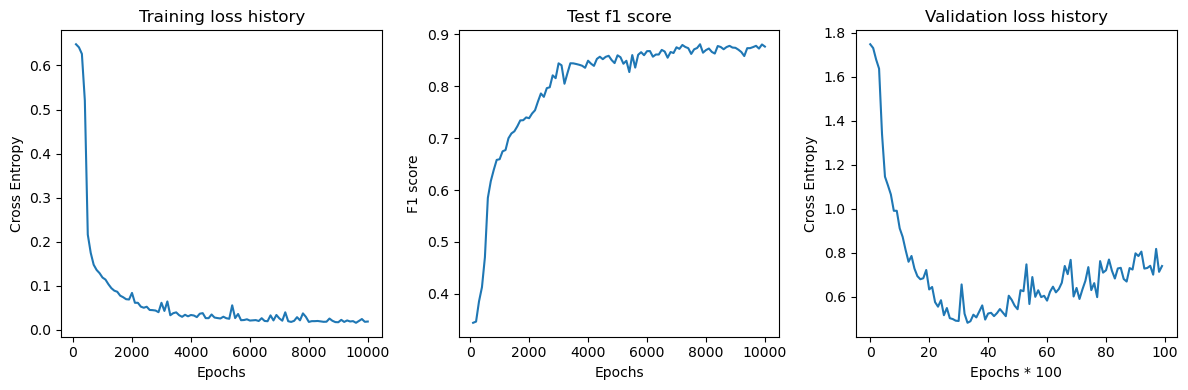

final f1 score: 0.876


In [59]:
plt.figure(figsize=(12,4))
plt.subplot(1, 3, 1)
history3.plot_loss(loss_type='train', return_plot=True)
plt.subplot(1, 3, 2)
history3.plot_loss(loss_type='test', return_plot=True)
plt.title('Test f1 score')
plt.ylabel('F1 score')
plt.subplot(1, 3, 3)
history3.plot_loss(loss_type='val', return_plot=True)
plt.title('Validation loss history')
plt.xlabel('Epochs * 100')
plt.tight_layout()
plt.show()
print(f"final f1 score: {round(nn3.f1_score(X_test3, y_test), 3)}")

In [62]:
# Widzimy, że po około 6500 epokach f1 score przestaje wzrastać, z kolei funkcja straty na zbiorze walidacyjnym zaczyna wzrastać już od około 4000 epoki 

- Validation early stopping

In [54]:
nn3_val = NeuralNetwork([2,10,10,3], model_type='classification')
history3_val = nn3_val.train(X_train3, y_train, learning_rate=0.01, info_interval=100, epochs=10000, batch_size=50,
    X_test=X_test3, y_test=y_test, optimize='moment', return_history=True, X_val=X_val3, y_val=y_val, window_size=5, val_stopping_k=5)

Epoch 100: Loss = 0.642 F1 score = 0.369 Val loss = 1.708
Epoch 200: Loss = 0.615 F1 score = 0.376 Val loss = 1.694
Epoch 300: Loss = 0.552 F1 score = 0.399 Val loss = 1.632
Epoch 400: Loss = 0.248 F1 score = 0.469 Val loss = 1.537
Epoch 500: Loss = 0.178 F1 score = 0.481 Val loss = 1.217
Epoch 600: Loss = 0.154 F1 score = 0.535 Val loss = 1.087
Epoch 700: Loss = 0.135 F1 score = 0.583 Val loss = 1.025
Epoch 800: Loss = 0.123 F1 score = 0.608 Val loss = 0.979
Epoch 900: Loss = 0.111 F1 score = 0.641 Val loss = 0.896
Epoch 1000: Loss = 0.1 F1 score = 0.655 Val loss = 0.847
Epoch 1100: Loss = 0.093 F1 score = 0.673 Val loss = 0.797
Epoch 1200: Loss = 0.084 F1 score = 0.692 Val loss = 0.726
Epoch 1300: Loss = 0.078 F1 score = 0.712 Val loss = 0.699
Epoch 1400: Loss = 0.073 F1 score = 0.731 Val loss = 0.67
Epoch 1500: Loss = 0.069 F1 score = 0.753 Val loss = 0.612
Epoch 1600: Loss = 0.066 F1 score = 0.764 Val loss = 0.59
Epoch 1700: Loss = 0.066 F1 score = 0.76 Val loss = 0.608
Epoch 1800:

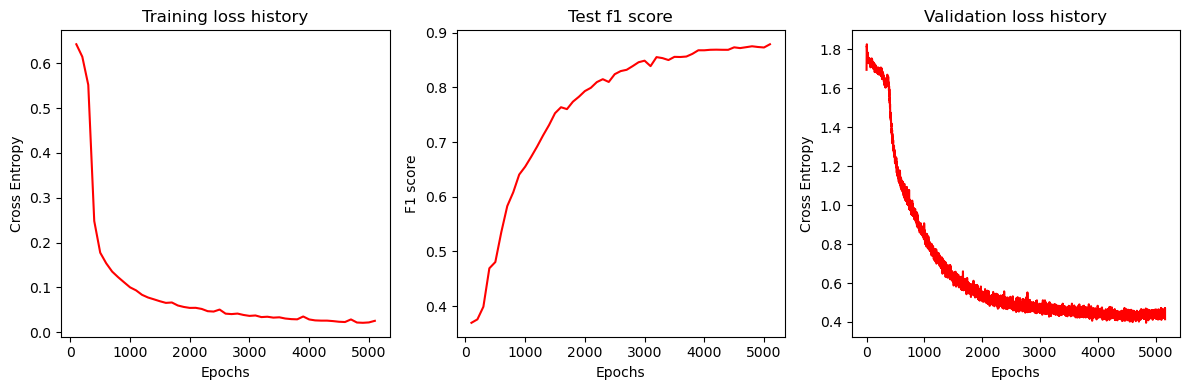

final f1 score: 0.879


In [63]:
plt.figure(figsize=(12,4))
plt.subplot(1, 3, 1)
history3_val.plot_loss(loss_type='train', return_plot=True, settings='r')
plt.subplot(1, 3, 2)
history3_val.plot_loss(loss_type='test', return_plot=True, settings='r')
plt.title('Test f1 score')
plt.ylabel('F1 score')
plt.subplot(1, 3, 3)
history3_val.plot_loss(loss_type='val', return_plot=True, settings='r')
plt.title('Validation loss history')
plt.tight_layout()
plt.show()
print(f"final f1 score: {round(nn3_val.f1_score(X_test3, y_test), 3)}")

In [66]:
# f1 score jest w zasadzie identyczny, jak w przypadku treningu bez early stoppingu, jednakże uzyskaliśmy ten wynik bez zbędnego dodatkowego treningu kilku tysięcy epok 

- Regularization

In [106]:
nn3_reg = NeuralNetwork([2,10,10,3], model_type='classification')
history3_reg = nn3_reg.train(X_train3, y_train, learning_rate=0.01, info_interval=100, epochs=10000, batch_size=50, l2_lambda=0.001,
    X_test=X_test3, y_test=y_test, optimize='moment', return_history=True, X_val=X_val3, y_val=y_val)

Epoch 100: Loss = 0.647 F1 score = 0.347 Val loss = 1.748
Epoch 200: Loss = 0.647 F1 score = 0.345 Val loss = 1.752
Epoch 300: Loss = 0.509 F1 score = 0.417 Val loss = 1.639
Epoch 400: Loss = 0.446 F1 score = 0.42 Val loss = 1.582
Epoch 500: Loss = 0.221 F1 score = 0.469 Val loss = 1.3
Epoch 600: Loss = 0.169 F1 score = 0.58 Val loss = 1.084
Epoch 700: Loss = 0.144 F1 score = 0.619 Val loss = 0.99
Epoch 800: Loss = 0.12 F1 score = 0.637 Val loss = 0.95
Epoch 900: Loss = 0.108 F1 score = 0.66 Val loss = 0.903
Epoch 1000: Loss = 0.101 F1 score = 0.695 Val loss = 0.798
Epoch 1100: Loss = 0.089 F1 score = 0.705 Val loss = 0.762
Epoch 1200: Loss = 0.081 F1 score = 0.714 Val loss = 0.709
Epoch 1300: Loss = 0.074 F1 score = 0.734 Val loss = 0.62
Epoch 1400: Loss = 0.07 F1 score = 0.751 Val loss = 0.581
Epoch 1500: Loss = 0.072 F1 score = 0.762 Val loss = 0.586
Epoch 1600: Loss = 0.06 F1 score = 0.783 Val loss = 0.551
Epoch 1700: Loss = 0.056 F1 score = 0.8 Val loss = 0.506
Epoch 1800: Loss = 

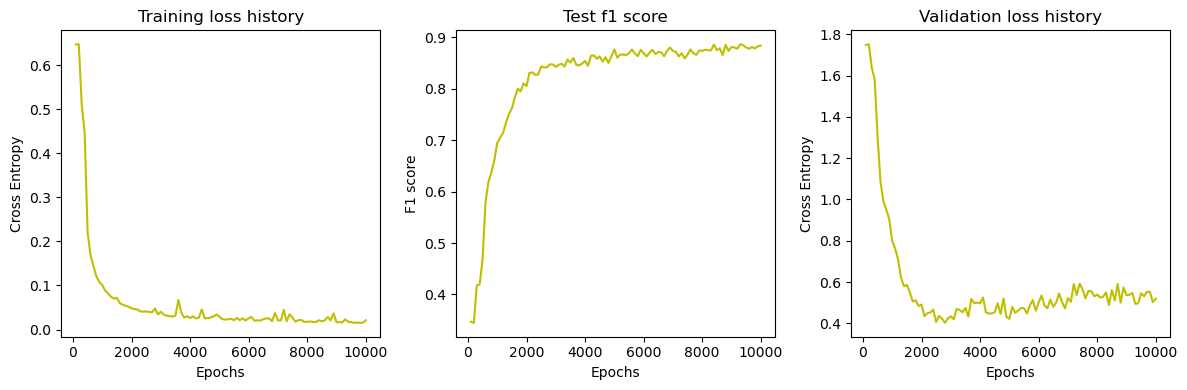

final f1 score: 0.884


In [108]:
plt.figure(figsize=(12,4))
plt.subplot(1, 3, 1)
history3_reg.plot_loss(loss_type='train', return_plot=True, settings='y')
plt.subplot(1, 3, 2)
history3_reg.plot_loss(loss_type='test', return_plot=True, settings='y')
plt.title('Test f1 score')
plt.ylabel('F1 score')
plt.subplot(1, 3, 3)
history3_reg.plot_loss(loss_type='val', return_plot=True, settings='y')
plt.title('Validation loss history')
plt.tight_layout()
plt.show()
print(f"final f1 score: {round(nn3_reg.f1_score(X_test3, y_test), 3)}")

In [122]:
# Wykresy metryk wyglądają w zasadzie identycznie jak bez regularyzacji. Zobaczmy jak wygląda podział klas:

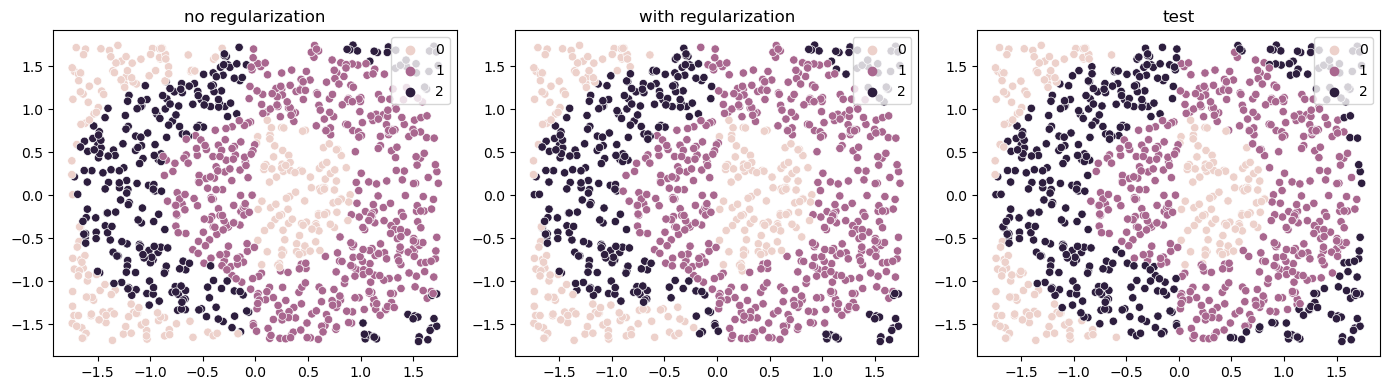

In [134]:
plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
nn3.plot_classes(X_test3)
plt.title('no regularization')
plt.subplot(1,3,2)
nn3_reg.plot_classes(X_test3)
plt.title('with regularization')
plt.subplot(1,3,3)
plot_classes(X_test3, decode_array(y_test))
plt.title('test')
plt.tight_layout()
plt.show()

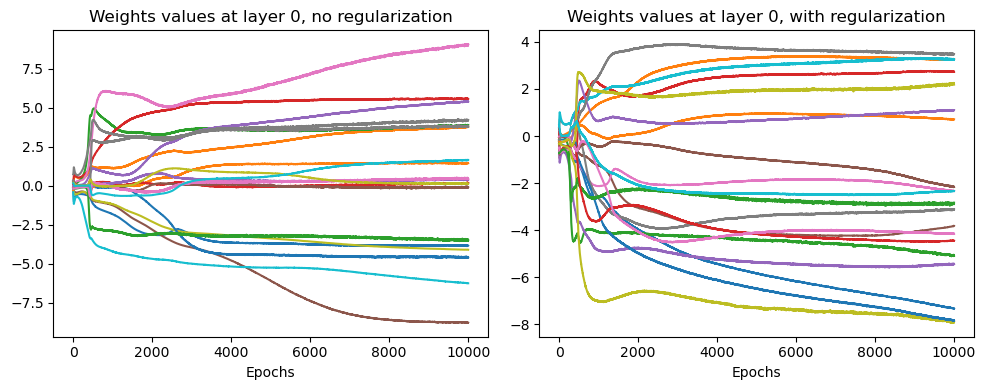

In [143]:
plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
history3.plot_weights(0, return_plot=True)
plt.title("Weights values at layer 0, no regularization")
plt.subplot(1, 2, 2)
history3_reg.plot_weights(0, return_plot=True)
plt.title("Weights values at layer 0, with regularization")
plt.tight_layout()
plt.show()

In [144]:
# Widzimy, że bez regularyzacji duża część wag pozostaje bardzo bliska zeru. W przypadku regularyzacji nie ma takowych, najprawdopobniej przez to, że zawsze dodajemy odrobinę "szumu". 

### rings 5

In [145]:
rings5_test = pd.read_csv("../dane/classification/rings5-sparse-test.csv")
rings5_train = pd.read_csv("../dane/classification/rings5-sparse-training.csv")

In [155]:
X_train = rings5_train[['x', 'y']].to_numpy()
y_train = one_hot_encode(rings5_train['c'])
X_val, X_test, y_val, y_test = train_test_split(rings5_test[['x', 'y']].to_numpy(), one_hot_encode(rings5_test['c']),
                                                test_size=0.5, random_state=42)
X_train5, _ = standardize_data(X_train)
X_test5, _ = standardize_data(X_test)
X_val5, _ = standardize_data(X_val)

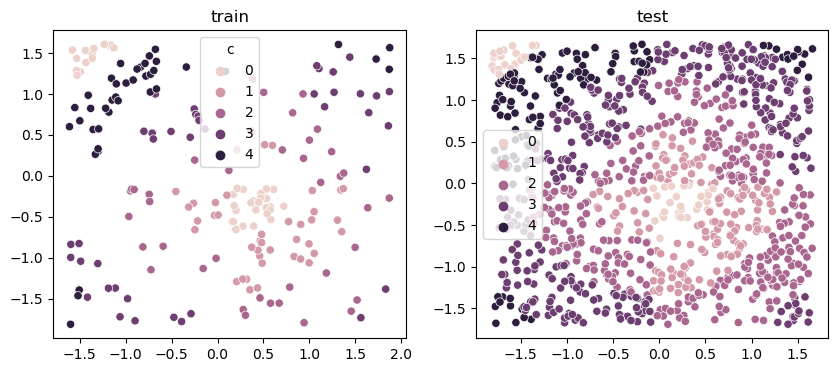

In [156]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title('train')
plot_classes(X_train5, rings5_train['c'])
plt.subplot(1,2,2)
plt.title('test')
plot_classes(X_test5, decode_array(y_test))

- Default model

In [157]:
nn5 = NeuralNetwork([2,10,10,5], model_type='classification')
history5 = nn5.train(X_train5, y_train, learning_rate=0.01, info_interval=100, epochs=10000, batch_size=50,
    X_test=X_test5, y_test=y_test, optimize='moment', return_history=True, X_val=X_val5, y_val=y_val)

Epoch 100: Loss = 1.538 F1 score = 0.222 Val loss = 1.556
Epoch 200: Loss = 1.366 F1 score = 0.247 Val loss = 1.445
Epoch 300: Loss = 1.332 F1 score = 0.282 Val loss = 1.421
Epoch 400: Loss = 1.316 F1 score = 0.315 Val loss = 1.402
Epoch 500: Loss = 1.293 F1 score = 0.344 Val loss = 1.375
Epoch 600: Loss = 1.253 F1 score = 0.379 Val loss = 1.331
Epoch 700: Loss = 1.189 F1 score = 0.402 Val loss = 1.268
Epoch 800: Loss = 1.115 F1 score = 0.441 Val loss = 1.202
Epoch 900: Loss = 1.05 F1 score = 0.451 Val loss = 1.147
Epoch 1000: Loss = 0.998 F1 score = 0.467 Val loss = 1.105
Epoch 1100: Loss = 0.955 F1 score = 0.497 Val loss = 1.077
Epoch 1200: Loss = 0.917 F1 score = 0.493 Val loss = 1.058
Epoch 1300: Loss = 0.882 F1 score = 0.494 Val loss = 1.039
Epoch 1400: Loss = 0.846 F1 score = 0.497 Val loss = 1.023
Epoch 1500: Loss = 0.801 F1 score = 0.503 Val loss = 0.996
Epoch 1600: Loss = 0.744 F1 score = 0.52 Val loss = 0.958
Epoch 1700: Loss = 0.696 F1 score = 0.576 Val loss = 0.927
Epoch 18

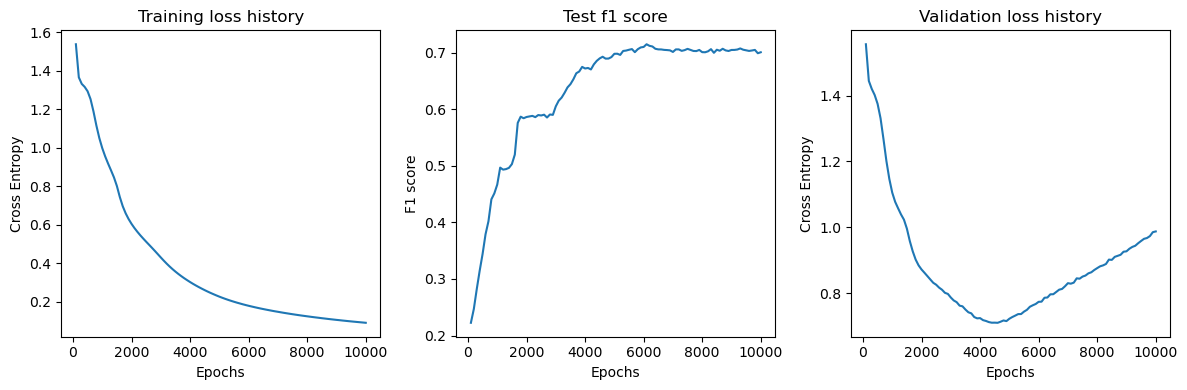

final f1 score: 0.701


In [161]:
plt.figure(figsize=(12,4))
plt.subplot(1, 3, 1)
history5.plot_loss(loss_type='train', return_plot=True)
plt.subplot(1, 3, 2)
history5.plot_loss(loss_type='test', return_plot=True)
plt.title('Test f1 score')
plt.ylabel('F1 score')
plt.subplot(1, 3, 3)
history5.plot_loss(loss_type='val', return_plot=True)
plt.tight_layout()
plt.show()
print(f"final f1 score: {round(nn5.f1_score(X_test5, y_test), 3)}")

- Validation early stopping

In [162]:
nn5_val = NeuralNetwork([2,10,10,5], model_type='classification')
history5_val = nn5_val.train(X_train5, y_train, learning_rate=0.01, info_interval=100, epochs=10000, batch_size=50, val_stopping_k=5, window_size=5,
    X_test=X_test5, y_test=y_test, optimize='moment', return_history=True, X_val=X_val5, y_val=y_val)

Epoch 100: Loss = 1.517 F1 score = 0.185 Val loss = 1.553
Epoch 200: Loss = 1.359 F1 score = 0.227 Val loss = 1.451
Epoch 300: Loss = 1.337 F1 score = 0.253 Val loss = 1.429
Epoch 400: Loss = 1.327 F1 score = 0.286 Val loss = 1.415
Epoch 500: Loss = 1.314 F1 score = 0.296 Val loss = 1.398
Epoch 600: Loss = 1.297 F1 score = 0.319 Val loss = 1.378
Epoch 700: Loss = 1.273 F1 score = 0.364 Val loss = 1.35
Epoch 800: Loss = 1.234 F1 score = 0.38 Val loss = 1.318
Epoch 900: Loss = 1.18 F1 score = 0.399 Val loss = 1.279
Epoch 1000: Loss = 1.12 F1 score = 0.404 Val loss = 1.235
Epoch 1100: Loss = 1.059 F1 score = 0.412 Val loss = 1.19
Epoch 1200: Loss = 1.002 F1 score = 0.45 Val loss = 1.15
Epoch 1300: Loss = 0.951 F1 score = 0.459 Val loss = 1.113
Epoch 1400: Loss = 0.907 F1 score = 0.457 Val loss = 1.087
Epoch 1500: Loss = 0.868 F1 score = 0.453 Val loss = 1.062
Epoch 1600: Loss = 0.832 F1 score = 0.462 Val loss = 1.042
Epoch 1700: Loss = 0.794 F1 score = 0.469 Val loss = 1.019
Epoch 1800: L

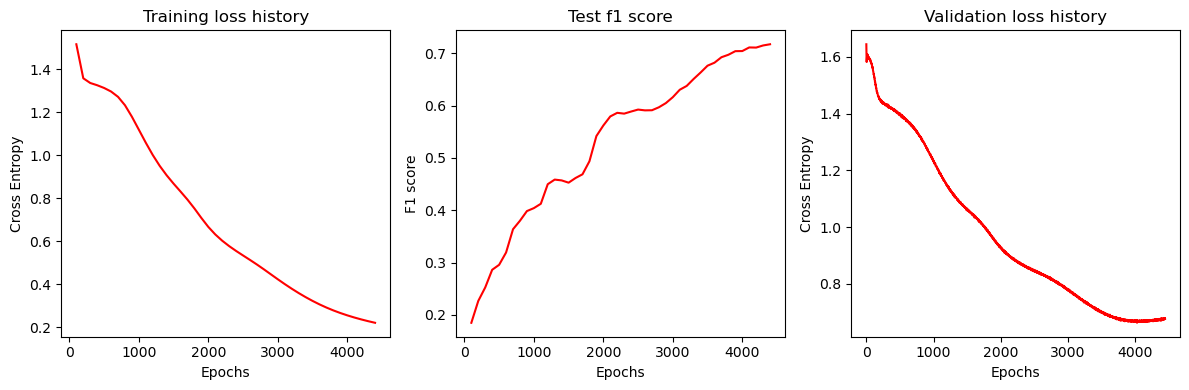

final f1 score: 0.717


In [177]:
plt.figure(figsize=(12,4))
plt.subplot(1, 3, 1)
history5_val.plot_loss(loss_type='train', return_plot=True, settings='r')
plt.subplot(1, 3, 2)
history5_val.plot_loss(loss_type='test', return_plot=True, settings='r')
plt.title('Test f1 score')
plt.ylabel('F1 score')
plt.subplot(1, 3, 3)
history5_val.plot_loss(loss_type='val', return_plot=True, settings='r')
plt.tight_layout()
plt.show()
print(f"final f1 score: {round(nn5_val.f1_score(X_test5, y_test), 3)}")

In [164]:
# Uzyskaliśmy lepszy f1 score, dzięki temu że zatrzymaliśmy trening odpowiednio wcześnie

- Regularization

In [167]:
nn5_reg = NeuralNetwork([2,10,10,5], model_type='classification')
history5_reg = nn5_reg.train(X_train5, y_train, learning_rate=0.01, info_interval=100, epochs=10000, batch_size=50, l2_lambda=0.001,
    X_test=X_test5, y_test=y_test, optimize='moment', return_history=True, X_val=X_val5, y_val=y_val)

Epoch 100: Loss = 1.535 F1 score = 0.134 Val loss = 1.568
Epoch 200: Loss = 1.365 F1 score = 0.237 Val loss = 1.458
Epoch 300: Loss = 1.334 F1 score = 0.289 Val loss = 1.43
Epoch 400: Loss = 1.319 F1 score = 0.324 Val loss = 1.41
Epoch 500: Loss = 1.297 F1 score = 0.346 Val loss = 1.386
Epoch 600: Loss = 1.258 F1 score = 0.379 Val loss = 1.343
Epoch 700: Loss = 1.196 F1 score = 0.393 Val loss = 1.286
Epoch 800: Loss = 1.113 F1 score = 0.419 Val loss = 1.219
Epoch 900: Loss = 1.033 F1 score = 0.434 Val loss = 1.157
Epoch 1000: Loss = 0.969 F1 score = 0.475 Val loss = 1.113
Epoch 1100: Loss = 0.919 F1 score = 0.469 Val loss = 1.077
Epoch 1200: Loss = 0.877 F1 score = 0.461 Val loss = 1.057
Epoch 1300: Loss = 0.841 F1 score = 0.464 Val loss = 1.036
Epoch 1400: Loss = 0.808 F1 score = 0.47 Val loss = 1.019
Epoch 1500: Loss = 0.774 F1 score = 0.479 Val loss = 1.001
Epoch 1600: Loss = 0.739 F1 score = 0.479 Val loss = 0.978
Epoch 1700: Loss = 0.704 F1 score = 0.485 Val loss = 0.956
Epoch 180

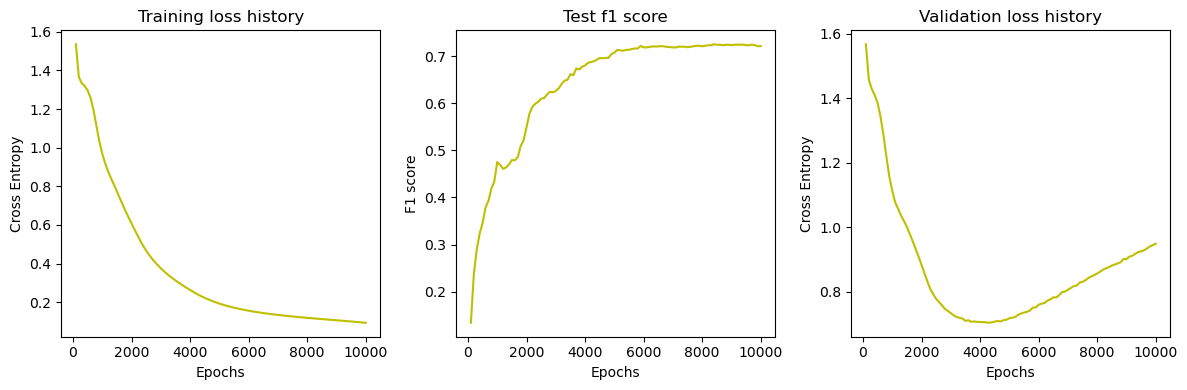

final f1 score: 0.721


In [178]:
plt.figure(figsize=(12,4))
plt.subplot(1, 3, 1)
history5_reg.plot_loss(loss_type='train', return_plot=True, settings='y')
plt.subplot(1, 3, 2)
history5_reg.plot_loss(loss_type='test', return_plot=True, settings='y')
plt.title('Test f1 score')
plt.ylabel('F1 score')
plt.subplot(1, 3, 3)
history5_reg.plot_loss(loss_type='val', return_plot=True, settings='y')
plt.tight_layout()
plt.show()
print(f"final f1 score: {round(nn5_reg.f1_score(X_test5, y_test), 3)}")

In [172]:
# Otrzymaliśmy najlepszy f1 score. Można zauważyć, że gdybyśmy zastosowali teraz early stopping, to trening zatrzymałby się około 4500 tysięcznej epoki, a w tym miejscu f1 score nie jest optymalny, 
# więc early stopping nie zawsze daje najlepsze możliwe wyniki. Na koniec porównanie 3 metod:

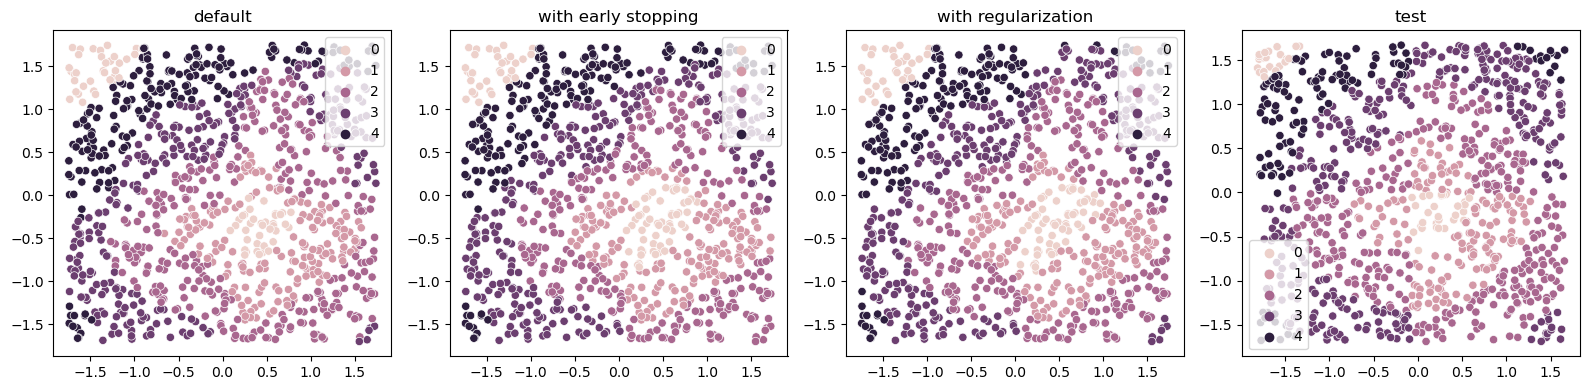

In [175]:
plt.figure(figsize=(16,4))
plt.subplot(1,4,1)
nn5.plot_classes(X_test3)
plt.title('default')
plt.subplot(1,4,2)
nn5_val.plot_classes(X_test3)
plt.title('with early stopping')
plt.subplot(1,4,3)
nn5_reg.plot_classes(X_test3)
plt.title('with regularization')
plt.subplot(1,4,4)
plot_classes(X_test5, decode_array(y_test))
plt.title('test')
plt.tight_layout()
plt.show()

In [176]:
# Na oko wszystkie metody poradziły sobie podobnie. Jednakże z regularyzacją otrzymaliśmy najlepszy f1 score, z kolei z early stoppingiem trening trwał 3 razy szybciej

### multimodal-large

In [179]:
multi_test = pd.read_csv("../dane/regression/multimodal-sparse-test.csv")
multi_train = pd.read_csv("../dane/regression/multimodal-sparse-training.csv")

In [284]:
X_train = multi_train['x']
y_train = multi_train['y']
X_test, X_val, y_test, y_val = train_test_split(multi_test['x'], multi_test['y'], random_state=42, test_size=0.5)
y_norm_modal, parameters_modal = standardize_data(y_train)

- Default model

In [228]:
nnm = NeuralNetwork([1,10,10,1], model_type='regression')
historym = nnm.train(X_train, y_norm_modal, learning_rate=0.1, info_interval=400, epochs=40000, batch_size=25,
                    optimize='moment', return_history=True, resize=True, denormalize=parameters_modal, X_test=X_test, y_test=y_test, X_val=X_val, y_val=y_val)

Epoch 400: Loss = 1680.464 test loss = 1953.499 Val loss = 2016.267
Epoch 800: Loss = 660.114 test loss = 1151.832 Val loss = 945.207
Epoch 1200: Loss = 256.794 test loss = 685.286 Val loss = 604.235
Epoch 1600: Loss = 239.359 test loss = 589.02 Val loss = 489.054
Epoch 2000: Loss = 227.744 test loss = 582.725 Val loss = 444.61
Epoch 2400: Loss = 226.115 test loss = 568.502 Val loss = 424.664
Epoch 2800: Loss = 244.792 test loss = 635.006 Val loss = 462.332
Epoch 3200: Loss = 221.052 test loss = 561.248 Val loss = 425.066
Epoch 3600: Loss = 220.759 test loss = 546.567 Val loss = 421.344
Epoch 4000: Loss = 232.162 test loss = 607.94 Val loss = 416.951
Epoch 4400: Loss = 245.489 test loss = 615.319 Val loss = 442.444
Epoch 4800: Loss = 229.472 test loss = 591.48 Val loss = 411.547
Epoch 5200: Loss = 221.261 test loss = 543.156 Val loss = 378.059
Epoch 5600: Loss = 226.497 test loss = 583.578 Val loss = 399.617
Epoch 6000: Loss = 219.69 test loss = 565.961 Val loss = 392.944
Epoch 6400: L

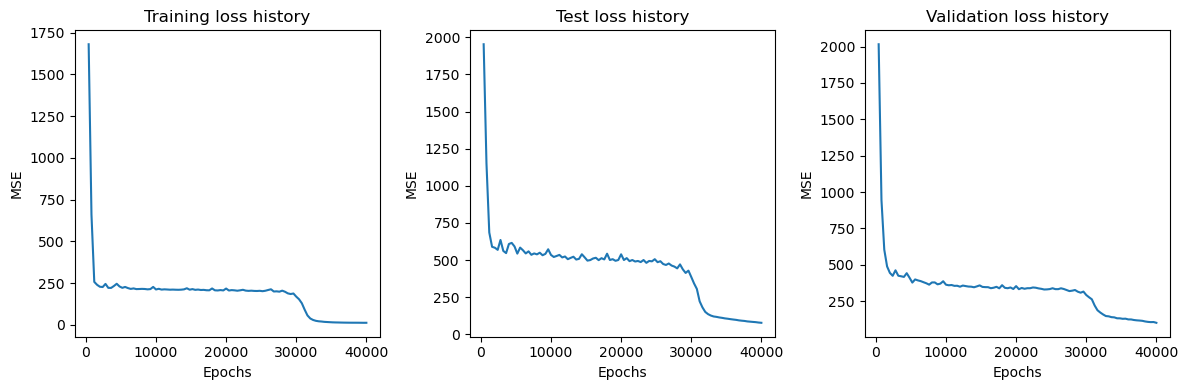

final mse: 77.067


In [229]:
plt.figure(figsize=(12,4))
plt.subplot(1, 3, 1)
historym.plot_loss(loss_type='train', return_plot=True)
plt.subplot(1, 3, 2)
historym.plot_loss(loss_type='test', return_plot=True)
plt.subplot(1, 3, 3)
historym.plot_loss(loss_type='val', return_plot=True)
plt.tight_layout()
plt.show()
print(f"final mse: {round(nnm.mse(X_test, y_test, resize=True, denormalize=parameters_modal), 3)}")

- Validation early stopping

In [222]:
nnm_val = NeuralNetwork([1,10,10,1], model_type='regression')
historym_val = nnm_val.train(X_train, y_norm_modal, learning_rate=0.1, info_interval=400, epochs=40000, batch_size=25, val_stopping_k=5, window_size=100,
                    optimize='moment', return_history=True, resize=True, denormalize=parameters_modal, X_test=X_test, y_test=y_test, X_val=X_val, y_val=y_val)

Epoch 400: Loss = 1551.562 test loss = 1806.891 Val loss = 1915.37
Epoch 800: Loss = 607.951 test loss = 1085.233 Val loss = 927.223
Epoch 1200: Loss = 250.739 test loss = 677.986 Val loss = 589.785
Epoch 1600: Loss = 222.487 test loss = 574.346 Val loss = 492.683
Epoch 2000: Loss = 219.7 test loss = 551.253 Val loss = 454.989
Epoch 2400: Loss = 216.634 test loss = 512.417 Val loss = 436.753
Epoch 2800: Loss = 227.945 test loss = 502.491 Val loss = 420.097
Epoch 3200: Loss = 217.632 test loss = 531.997 Val loss = 423.703
Epoch 3600: Loss = 213.87 test loss = 512.356 Val loss = 386.197
Epoch 4000: Loss = 214.815 test loss = 529.347 Val loss = 391.039
Epoch 4400: Loss = 211.513 test loss = 516.504 Val loss = 385.545
Epoch 4800: Loss = 211.884 test loss = 515.318 Val loss = 397.744
Epoch 5200: Loss = 210.782 test loss = 510.472 Val loss = 385.394
Epoch 5600: Loss = 211.694 test loss = 515.783 Val loss = 369.493
Epoch 6000: Loss = 210.853 test loss = 490.833 Val loss = 368.54
Epoch 6400: L

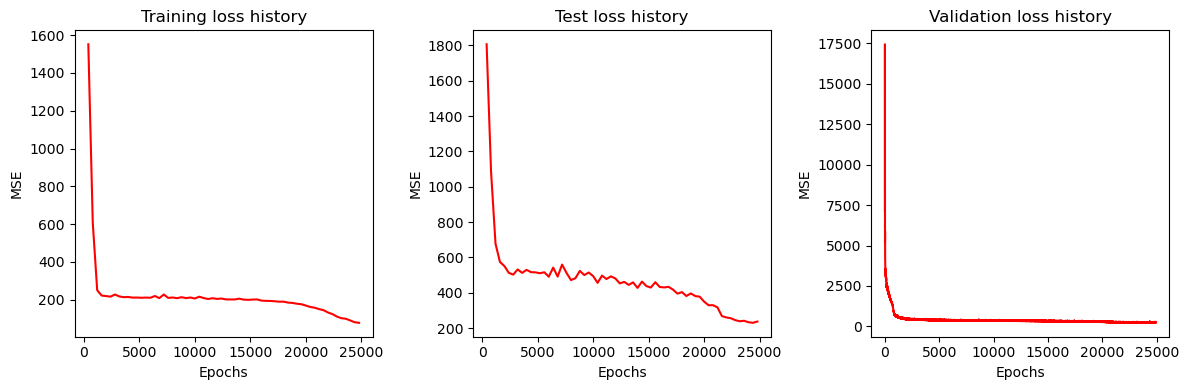

final mse: 231.83


In [285]:
plt.figure(figsize=(12,4))
plt.subplot(1, 3, 1)
historym_val.plot_loss(loss_type='train', return_plot=True, settings='r')
plt.subplot(1, 3, 2)
historym_val.plot_loss(loss_type='test', return_plot=True, settings='r')
plt.subplot(1, 3, 3)
historym_val.plot_loss(loss_type='val', return_plot=True, settings='r')
plt.tight_layout()
plt.show()
print(f"final mse: {round(nnm_val.mse(X_test, y_test, resize=True, denormalize=parameters_modal), 3)}")

In [230]:
# Widzimy, że early stopping nie zawsze się sprawdza. Pomimo tego, że długo nic się nie zmienia, to około 30000 epoki mse drastycznie spada. Early stopping jednak zatrzymuje trening nieco wcześniej,
# przez to nie dochodzi do optymalnej wartości.

- Regularization

In [251]:
nnm_reg = NeuralNetwork([1,10,10,1], model_type='regression')
historym_reg = nnm_reg.train(X_train, y_norm_modal, learning_rate=0.1, info_interval=400, epochs=40000, batch_size=25, l2_lambda=0.001,
                    optimize='moment', return_history=True, resize=True, denormalize=parameters_modal, X_test=X_test, y_test=y_test, X_val=X_val, y_val=y_val)

Epoch 400: Loss = 1731.949 test loss = 1909.187 Val loss = 1980.949
Epoch 800: Loss = 692.914 test loss = 1068.622 Val loss = 931.572
Epoch 1200: Loss = 373.638 test loss = 756.451 Val loss = 583.909
Epoch 1600: Loss = 248.011 test loss = 565.492 Val loss = 505.877
Epoch 2000: Loss = 244.944 test loss = 542.127 Val loss = 507.729
Epoch 2400: Loss = 229.731 test loss = 558.399 Val loss = 514.382
Epoch 2800: Loss = 250.81 test loss = 543.742 Val loss = 470.967
Epoch 3200: Loss = 227.171 test loss = 562.071 Val loss = 452.834
Epoch 3600: Loss = 223.241 test loss = 535.057 Val loss = 449.478
Epoch 4000: Loss = 237.624 test loss = 581.039 Val loss = 485.872
Epoch 4400: Loss = 234.777 test loss = 533.503 Val loss = 436.144
Epoch 4800: Loss = 239.143 test loss = 540.828 Val loss = 415.112
Epoch 5200: Loss = 224.649 test loss = 521.645 Val loss = 420.027
Epoch 5600: Loss = 260.713 test loss = 607.391 Val loss = 500.025
Epoch 6000: Loss = 267.155 test loss = 544.964 Val loss = 429.977
Epoch 640

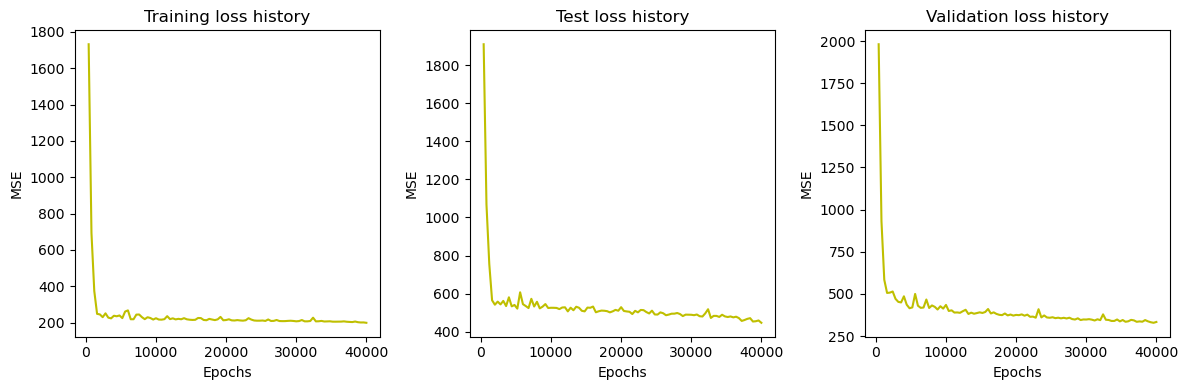

final mse: 447.22


In [286]:
plt.figure(figsize=(12,4))
plt.subplot(1, 3, 1)
historym_reg.plot_loss(loss_type='train', return_plot=True, settings='y')
plt.subplot(1, 3, 2)
historym_reg.plot_loss(loss_type='test', return_plot=True, settings='y')
plt.subplot(1, 3, 3)
historym_reg.plot_loss(loss_type='val', return_plot=True, settings='y')
plt.tight_layout()
plt.show()
print(f"final mse: {round(nnm_reg.mse(X_test, y_test, resize=True, denormalize=parameters_modal), 3)}")

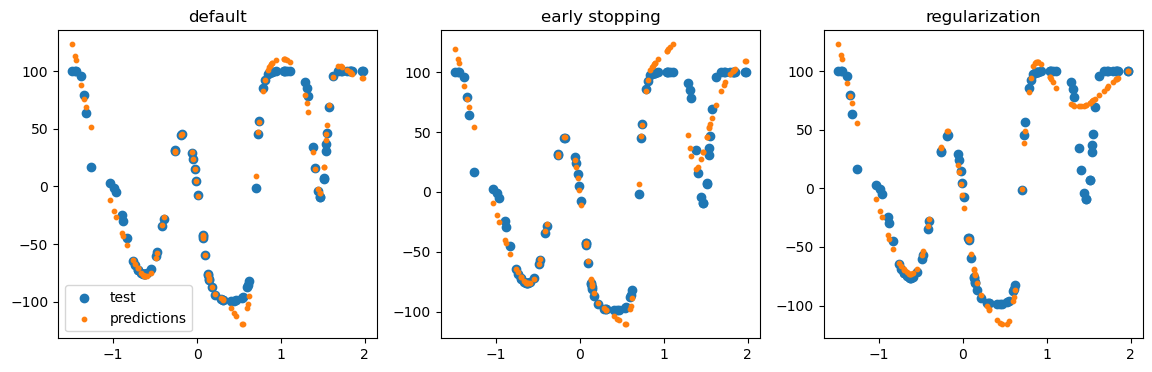

In [253]:
plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
preds_modal = nnm.predict(X_test.to_numpy().reshape(-1,1))
preds_modal_denorm = destandardize_data(preds_modal, parameters_modal)
plt.scatter(X_test, y_test)
plt.scatter(X_test, preds_modal_denorm, s=10)
plt.legend(['test', 'predictions'])
plt.title('default')

plt.subplot(1,3,2)
preds_modal = nnm_val.predict(X_test.to_numpy().reshape(-1,1))
preds_modal_denorm = destandardize_data(preds_modal, parameters_modal)
plt.scatter(X_test, y_test)
plt.scatter(X_test, preds_modal_denorm, s=10)
plt.title('early stopping')

plt.subplot(1,3,3)
preds_modal = nnm_reg.predict(X_test.to_numpy().reshape(-1,1))
preds_modal_denorm = destandardize_data(preds_modal, parameters_modal)
plt.scatter(X_test, y_test)
plt.scatter(X_test, preds_modal_denorm, s=10)
plt.title('regularization')

plt.show()

In [256]:
# Regularyzacja zupełnie nie działa, early stopping też nie pomógł

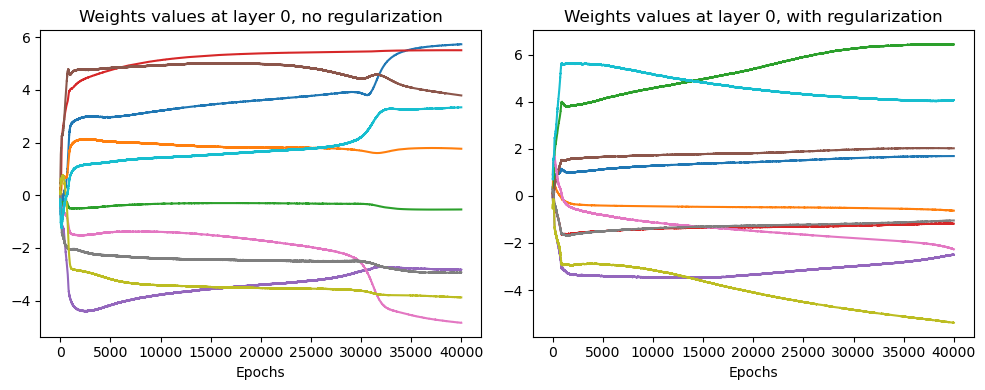

In [280]:
plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
historym.plot_weights(2, return_plot=True)
plt.title("Weights values at layer 0, no regularization")
plt.subplot(1, 2, 2)
historym_reg.plot_weights(2, return_plot=True)
plt.title("Weights values at layer 0, with regularization")
plt.tight_layout()
plt.show()

### xor3

In [263]:
xor_test = pd.read_csv("../dane/classification/xor3-balance-test.csv", index_col=0).reset_index()
xor_train = pd.read_csv("../dane/classification/xor3-balance-training.csv", index_col=0).reset_index()

In [264]:
X_train = xor_train[['x', 'y']].to_numpy()
y_train = one_hot_encode(xor_train['c'])
X_val, X_test, y_val, y_test = train_test_split(xor_test[['x', 'y']].to_numpy(), one_hot_encode(xor_test['c']),
                                                test_size=0.5, random_state=42)
X_train_xor, _ = standardize_data(X_train)
X_test_xor, _ = standardize_data(X_test)
X_val_xor, _ = standardize_data(X_val)

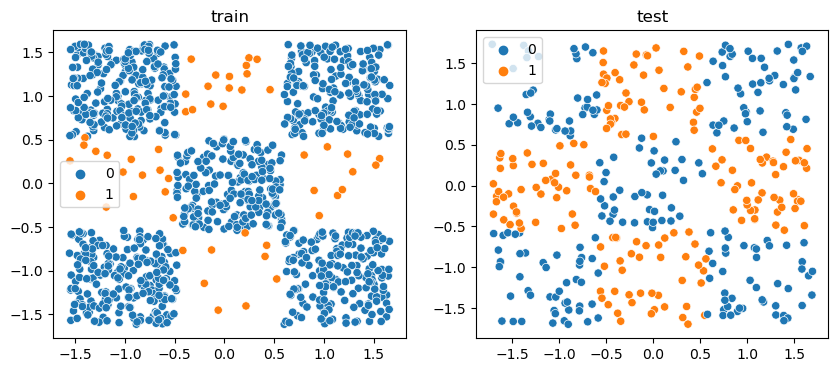

In [248]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plot_classes(X_train_xor, decode_array(y_train))
plt.title('train')
plt.subplot(1,2,2)
plot_classes(X_test_xor, decode_array(y_test))
plt.title('test')
plt.show()

Dla tego zestawu sprawdzimy różne wartości regularyzacji

6it [03:53, 38.99s/it]


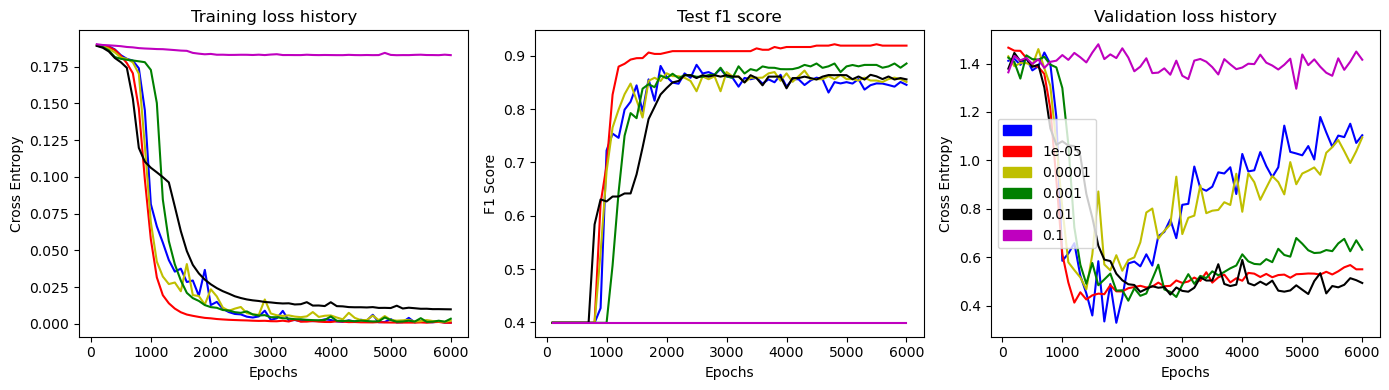

In [274]:
lambdas = [None, 0.00001, 0.0001, 0.001, 0.01, 0.1]
colors = ['b', 'r', 'y', 'g', 'k', 'm']
legend_handles = [Patch(color=color, label=label) for label, color in zip(lambdas, colors)]

plt.figure(figsize=(14,4))
for l2_lambda, color in tqdm(zip(lambdas, colors)):
    nn_xor = NeuralNetwork([2,10,10,2], model_type='classification')
    history_xor = nn_xor.train(X_train_xor, y_train, learning_rate=0.05, info_interval=100, epochs=6000, batch_size=50, l2_lambda=l2_lambda,
        X_test=X_test_xor, y_test=y_test, optimize='moment', return_history=True, X_val=X_val_xor, y_val=y_val, mute_print=True)
    
    plt.subplot(1, 3, 1)
    history_xor.plot_loss(loss_type='train', return_plot=True, settings=color)
    plt.subplot(1, 3, 2)
    history_xor.plot_loss(loss_type='test', return_plot=True, settings=color)
    plt.title('Test f1 score')
    plt.ylabel('F1 Score')
    plt.subplot(1, 3, 3)
    history_xor.plot_loss(loss_type='val', return_plot=True, settings=color)
    plt.tight_layout()
plt.legend(handles=legend_handles)

In [281]:
# Widzimy, że w przypadku gdy nasze dane potrzebują uogólnienia, najlepsze wyniki daje nieduża wartość współczynnika regularyzacji. 